# Rayne Davidson
**GISC 405 Assignment 4**

## Q1 NIWA


### 1.1 CMIP
**What is CMIP?**

CMIP - "Coupled Model Inter-Comparison Project"


CMIP is a project/initiative that is aimed at providing a variety climate models to compare with one another to help identify the differences and uncertainties of the variety of models, by comparing the different models and their results. It aims to create models that can predict climate on a large scale based on historic climate data, under different future scenarios. 


CMIP uses a set of simulations that follow a "standard" or protocols, to evaluate how realistic the models could be at predicting future and past climate and to maintain consistency across the variety of models. 


CMIP 6 is the most recent CMIP. 



https://pcmdi.llnl.gov/mips/cmip5/

### 1.2 Earth System Model
**What is an Earth System Model?**

Earth System Models are, in essence, any simulated model that has to do with Earth and it's processes and interactions. They are often used for climate models, but can also be used for other Earthly processes such as simulations of geologic processes, oceanic processes, and chemical processes. 


In the context of climate, Earth system models can simulate the interactions between the atmosphere, oceans, land, ice, etc to simulate and predict future conditions like increased greenhouse gases and what affect that would have on the earth

### 1.3 Dynamic Downscaling
**Why do we need to dynamically downscale these model outputs?**

Unfortunately (Fortunately?) the Earth is pretty large. Changes in climate generally affect the whole planet, so these models need to exist on a planet-wide scale, but to observe the impacts in specific areas or regions the models need to be 'dynamically' downscaled to increase the resolution and detail needed on smaller local or regional scale. 

### 1.4 Statistic vs Dynamic Downscaling
**What is the main difference between statistically and dynamically downscaled data? Strengths and weaknesses?**

Dynamic downscaling can capture a larger range and diversity of features, that is high in resolution. Dynamic downscaling incorporates both earth system models and smaller regional models to capture local high resolution and larger physical processes. Statistic downscaling uses, shockingly, statistics to numerically transform coarser data like earth system model data to a higher resolution. Statistic dwonscaling does not explicitly simulate the actual physical processes, where dynamic downscaling does simulate physical processes of earth.


dynamic downscaling is expensive (in terms of resouces and computation), and has more room for error due to unkonwns in either the regional model or earth system model, as is reliant on just one earth system model. 


statistical downscaling does not simulate physical processes and assumes that the relationships it simulates are static and do not, or will not change in the future. However, it is less computationally expensive. 



as far as *main* difference, I would say the ability to model physical properties - one is physics and "physical processes" based, where the other is numerical.

## Q2 FWI Projections

In [1]:
import numpy as np
import xarray as xr 
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns 

In [2]:
data=(xr.open_mfdataset(
            '/mnt/data/CMIP5_RCP60_FWI/*noresm1-m_rcp60*',
            chunks={"time":24,"height":1},
            parallel=True))

maskProvided=(xr.open_mfdataset(
            '/mnt/data/CMIP5_RCP60_FWI/lsm*',
            chunks={"time":24,"height":1},
            parallel=True))

In [3]:
# I beefed this up because I was procrastinating doing another assignment
# i was also trying to do something new (to me, anyway) with the functions
# sorry if/that it is obnoxious

def fiveYearIntervals(start, end):
    yearstart=start
    yearsend=end
    yearslist=[]

    for year in range(yearstart, yearsend, 5):
        
            yearstart=str(year)
            yearend=str(year+4)            
            yearslist.append([yearstart, yearend])
        
    return yearslist


# ---------------------------------
def FWIover30_perPeriod(datesList):
    
    mask=maskProvided.lsm
    land=mask.where(mask==1)
    
    Interval=data.FWI.sel(time=slice(datesList[0], datesList[-1]))
    ExtremeInterval=Interval.where((mask==land) & (Interval>=30))
    ExtremeCount=ExtremeInterval.count(dim="time")

    return ExtremeCount


# ---------------------------------
def plot_onePeriod_FWI_NZ(year, ax):
    
    data=FWIover30_perPeriod(year)
    
    cmap=mpl.colormaps["RdYlBu_r"]
    cmap.set_under(color="white") # mask out the ocean values (0)
    
    data.plot(ax=ax, vmax=1000, vmin=0.1, cmap=cmap)
    ax.set_title(f"Days of FWI > 30 from {year[0]} to {year[1]} in New Zealand", fontsize=20)
    ax.grid(zorder=100, which="both", axis="both", linestyle="--")
    
    return 


# ---------------------------------
def FWI_distribution_perPeriod(year, ax):
    
    data=FWIover30_perPeriod(year)
    
    maskeddata=np.ma.masked_equal(data, 0)
    noZerosData=maskeddata.compressed()
    
    AvgNum_DaysPerYear_Over30=noZerosData/5
    percentPerYear=(AvgNum_DaysPerYear_Over30/365)*100
    
    h=sns.histplot(data=percentPerYear, ax=ax, kde=True, color="red", bins=20)
    h.set_xlabel("Location", fontsize=10)
    h.set_ylabel("Avg % of Year where FWI >30", fontsize=10)
    h.set_title(f'Avg Percent of Year where FWI>30 from {year[0]} to {year[1]}', fontsize=20, pad=15)
    h.set_ylim(0, 40)
  
    return


# ---------------------------------
def make_years_readable(years):
    
    joinedYears=[]
    for e in years:
        e.insert(1, "to")
        joinedYears.append(' '.join([str(item) for item in e]))
        
    return joinedYears


# ---------------------------------
def statistics_df(stats):
    
    statdf=pd.DataFrame(stats[:-1])
    statdf=statdf.T
    statdf.columns=stats[-1]
    
    return statdf


# ---------------------------------
def stats_by_period_table(years, maxlistname, meanlistname):
    
    stats=stats_lists(years, maxlistname, meanlistname)
    statsdf=statistics_df(stats)
    stats_table(statsdf)
    
    return 


# ---------------------------------
def stats_table(statsdf):
    
    stat_table=plt.table(cellText=statsdf.values, colLabels=statsdf.columns, loc='left', bbox=[-1.4,-1,2,.7], cellLoc="center")
    stat_table.auto_set_font_size(False)
    stat_table.set_fontsize(15)
    
    return


# ---------------------------------
def get_period_stats(year, maxlistname, meanlistname):
    
    data=FWIover30_perPeriod(year)
    
    chunkMax=data.values.max()
    maxlistname.append(chunkMax)
    chunkMean=np.mean(data.values)
    meanlistname.append(chunkMean)
    
    return


# ---------------------------------
def stats_lists(years, maxlistname, meanlistname):
    
    joinedYears=make_years_readable(years)
    headers=["Period:", "Maximum incidents of FWI>30:", "Mean incidents of FWI>30:"]
    
    stats=[joinedYears, maxlistname, meanlistname, headers]
    
    return stats


# ---------------------------------
def plot_Map_and_Histogram_perPeriod(year, axes, row):

    plot_onePeriod_FWI_NZ(year, axes[row,0])
    FWI_distribution_perPeriod(year, axes[row, 1])
    
    return


# ---------------------------------
def FWI_preditions(data):
    fig, axes=plt.subplots(nrows=4,ncols=2, squeeze=True, figsize=(15,20))
    fig.tight_layout(pad=4.5)

    row=-1
    maxlist=[]
    meanlist=[]
    yearslist=fiveYearIntervals(2020, 2040)

    for year in yearslist:
        row=row+1

        get_period_stats(year, maxlist, meanlist)
        plot_Map_and_Histogram_perPeriod(year, axes, row)

    stats_by_period_table(yearslist, maxlist, meanlist)
    
    return

### FWI projection plots

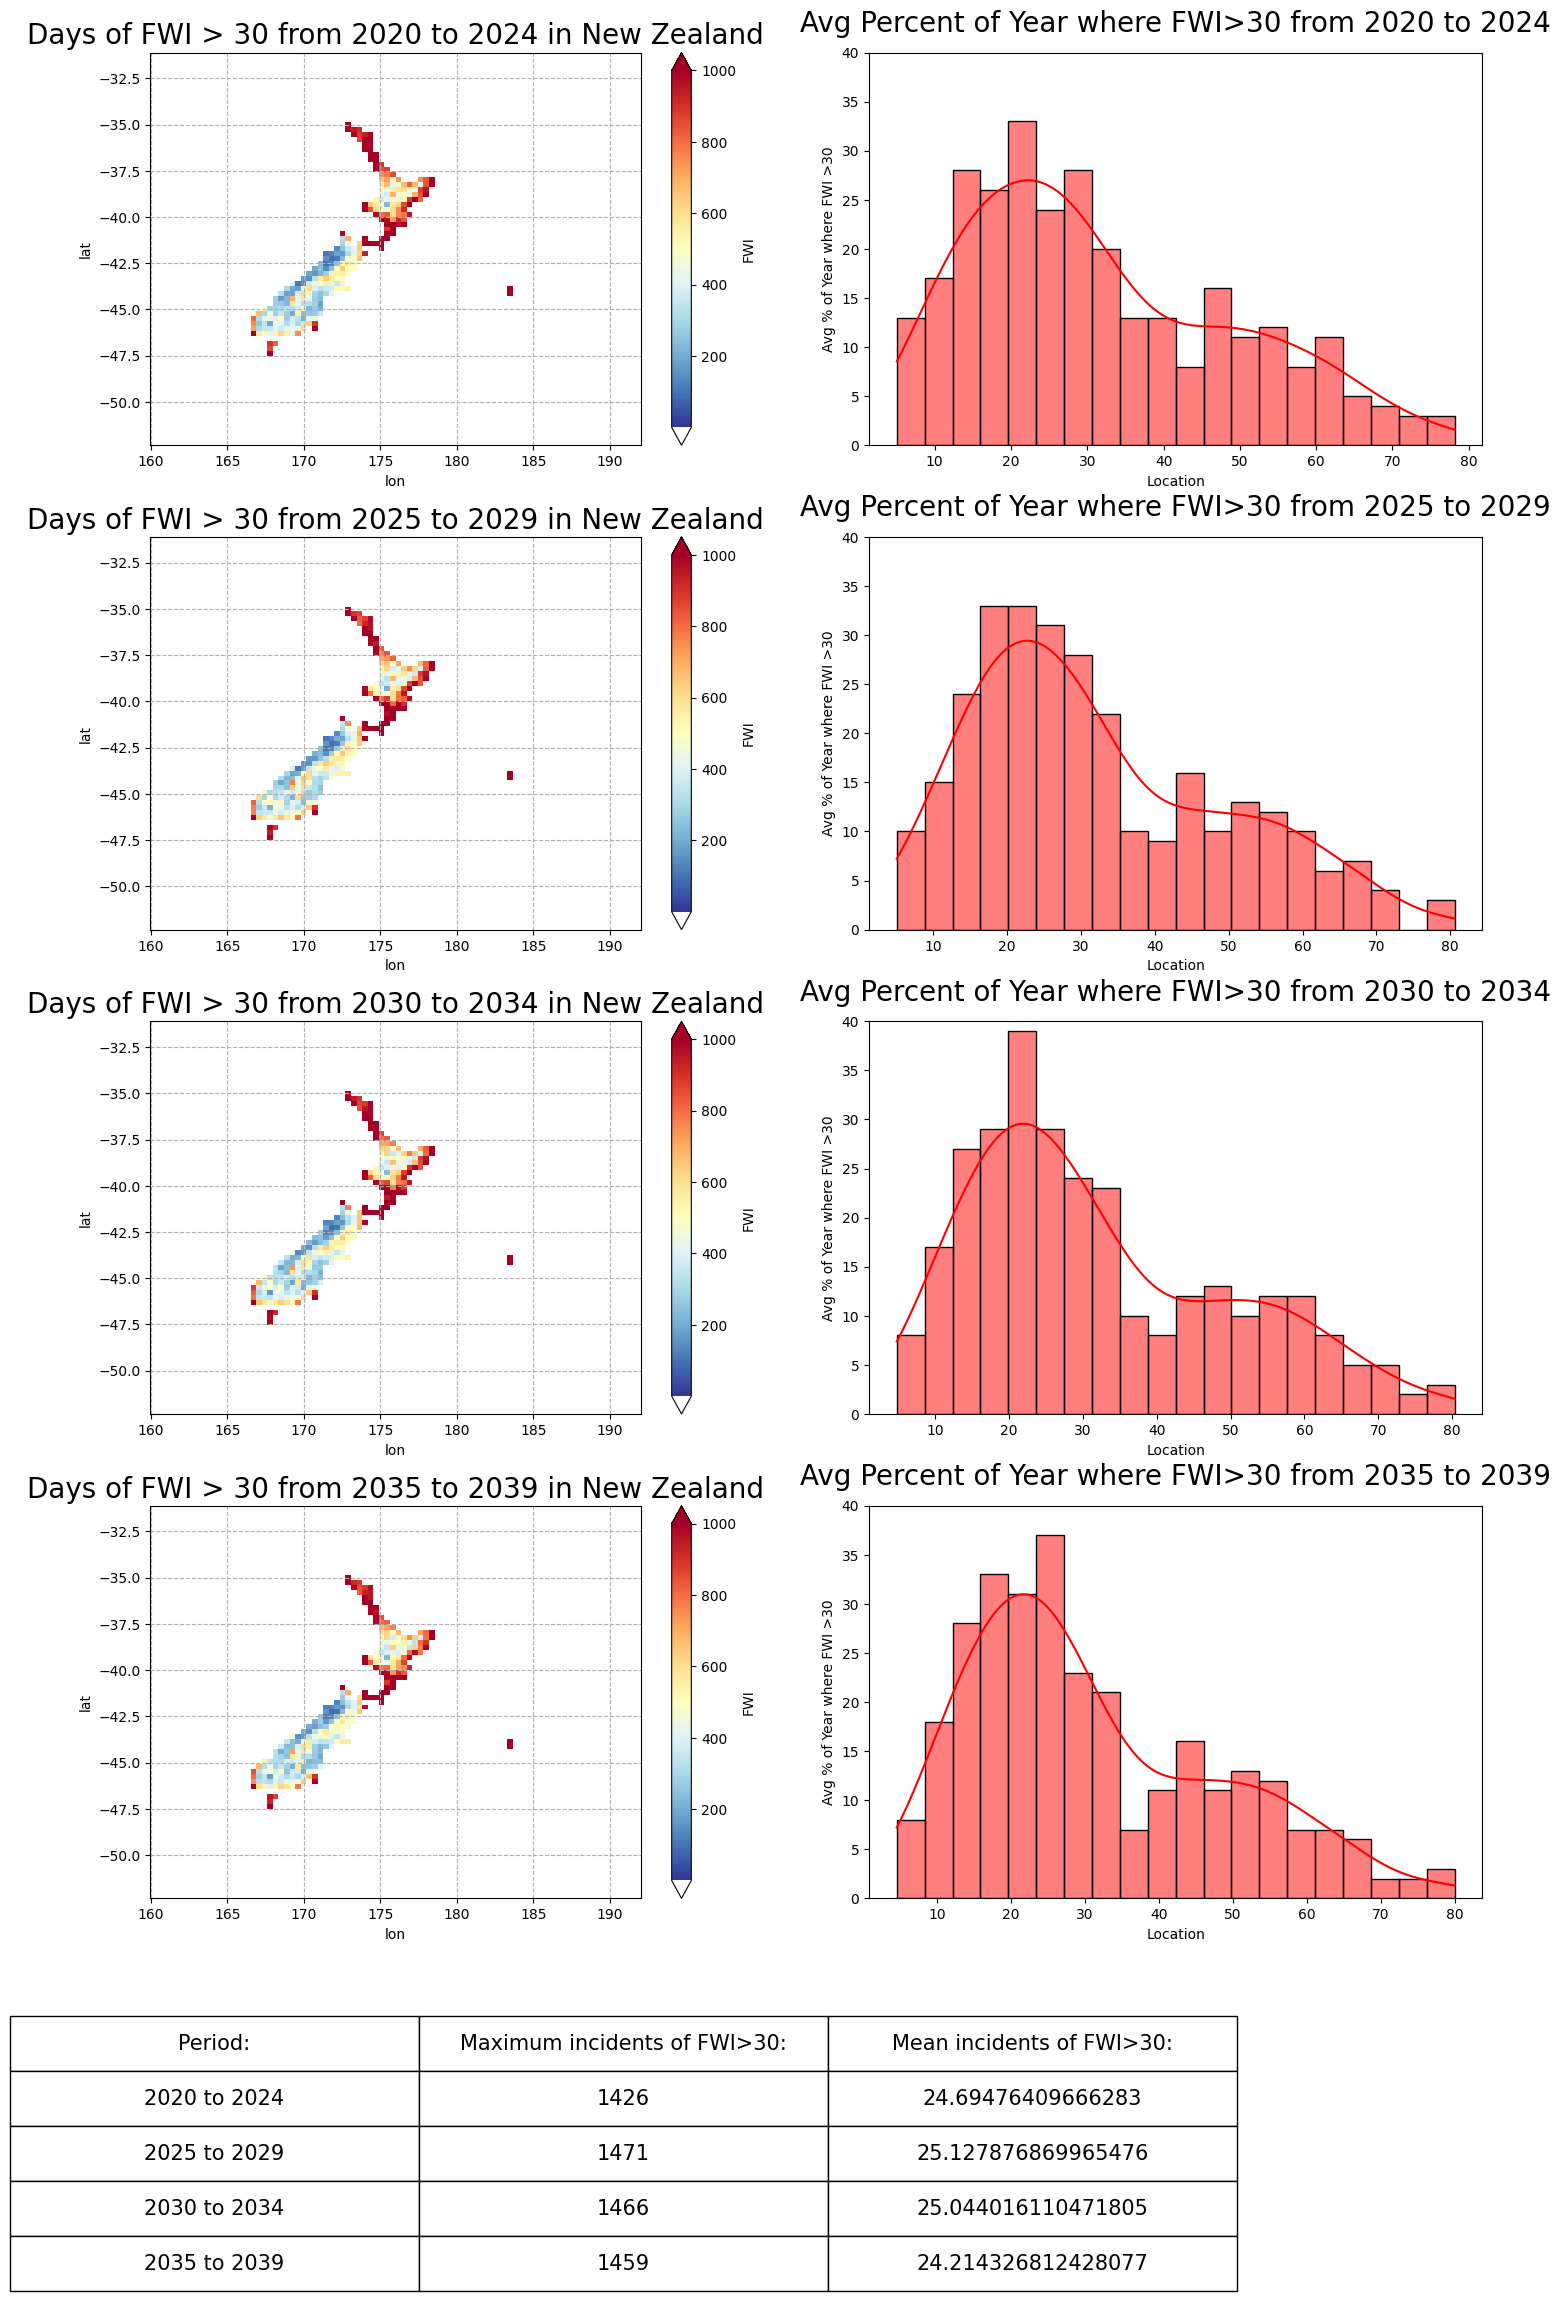

In [4]:
FWI_preditions(data)

# i have tried very hard to get this to be orthographically projected and have been unsuccessful

*I made the histograms and table to confirm that the values were actually different, because visually the plots look....the same and I thought I was going crazy*

### Comments

**Based on your results from assignment 3, provide a commentary on the spatial variability of the exceedances**

In assignment 3, the FWI exceedances of 31 in the summer of 2016-2017 primarily were located on the east coast of both the north and south island, with a higher density of exceedances on the SE coast of the north island. The north/NW section of the north island also displayed some higher instances of FWI exceedance, and the canterbury region as well. 


Compared to the predicted FWI in this assignment, the east coast of the north island is consistent with higher instances of increased FWI, however it has been extended as well to the south area of the north island and the north area of the north island has a much higher incidence rate than it did in the 2016/2017 data. The southern tip of the south island also displays some higher instances of FWI>30, which was not displayed in the 2016/2017 plot. The 2016/2017 plot showed increased FWI instances in ther canterbury region, which is not present (or present enough to be notable) in the projected FWI data. I do find it surprisingly that the west coast of the south island isnt more "low"/blue, and that the west coast of the north island is so "high"/red in the predicted data. 


The predicted data appears to project the coastal areas of the north island, and the south tip of the south island to become more dry, as compared to the 2016/2017 data. I am not a climate scientist or specialist but I don't overly find that exceptionally surprising, given it's proximity to the equator. There is, however, very little change across the predicted data between 2020 and 2040. 

# A little for fun

I asked ChatGPT to just check my answers for accuracy (my answers were my own, dont worry), and it summarized what I said in better, definitely more professional words. Here they are if you're interested. I personally found this pretty neat and even having my own words summarized back to me helped me understand it a bit better. I hope you wont mind this since we talked about chatgpt being a tool in class: 


**What is CMIP?**
Here's a summary of your response:

- CMIP is an initiative that involves the comparison of various climate models to understand their differences and uncertainties. Its primary goal is to assess and compare the performance of different climate models by evaluating their ability to simulate past and predict future climate on a global scale.

- CMIP follows standardized protocols or guidelines for conducting simulations to ensure consistency and comparability across the models. These protocols define how the models should be initialized, the scenarios or conditions to be simulated (e.g., historical climate, future climate under specific greenhouse gas emissions), and the variables to be recorded.

- By comparing the outputs of multiple climate models, CMIP aims to improve our understanding of climate processes and reduce uncertainties in climate projections. It helps identify areas of agreement and divergence among models, allowing scientists to assess the robustness and reliability of climate projections.

- CMIP6 refers to the sixth phase of CMIP, which is the most recent phase as of my knowledge cutoff in September 2021. Each CMIP phase represents a new generation of climate models, incorporating updated scientific knowledge, improved modeling techniques, and enhanced representation of Earth system components.

Overall, your explanation provides an accurate overview of CMIP and its purpose.



**What is an Earth System Model?**
 Here's a summary of your response:

- An Earth System Model (ESM) is a simulated model that encompasses various Earth processes and their interactions. ESMs are used to study and simulate not only climate-related phenomena but also other Earth processes such as geologic processes, oceanic processes, and chemical processes.

- In the context of climate, ESMs are particularly relevant as they can simulate and predict future conditions by considering the interactions between different components of the Earth system. These components typically include the atmosphere, oceans, land surface, and ice. ESMs simulate the exchange of energy, water, carbon, and other relevant substances between these components, allowing for the investigation of complex feedback mechanisms and the assessment of the impacts of factors like increased greenhouse gas concentrations on the Earth's climate.

- ESMs play a vital role in understanding how the Earth system functions and how it responds to various external forcings, including human-induced changes. They help scientists study long-term climate trends, project future climate scenarios, and assess the potential consequences of environmental changes on a global scale.

Overall, your explanation provides an accurate overview of Earth System Models and their significance in studying Earth processes, including climate-related phenomena.



**Why do we need to dynamically downscale these model outputs?**
Here's a summary of your response:

- The Earth is a large and complex system, and climate changes have global implications. Earth system models are designed to capture the overall planetary-scale processes and interactions. However, to understand the localized impacts and variations in specific areas or regions, the models need to be downscaled to smaller, local or regional scales. This downscaled data provides higher resolution and detail, enabling the observation of climate impacts on a more localized level.

- Dynamically downscaling Earth system model outputs involves using regional climate models (RCMs) nested within global climate models (GCMs). RCMs simulate climate processes at a higher resolution within a specific region of interest, capturing local-scale features such as topography, land cover, and coastline. By incorporating these regional factors and increasing the resolution, dynamically downscaled models can provide more accurate representations of climate patterns and their impacts at local or regional scales.

- The purpose of dynamic downscaling is to bridge the gap between the coarse-resolution global-scale models and the finer-scale information needed for localized assessments, such as studying the impacts of climate change on specific ecosystems, cities, or vulnerable regions. It helps researchers and decision-makers understand the potential regional consequences of global climate changes and aids in developing localized adaptation strategies.

Overall, your explanation effectively highlights the need for dynamically downscaling Earth system model outputs to observe climate impacts in specific areas or regions, where higher resolution and detail are required beyond the global-scale models.



**Mian differences between statistically and dynamically downscaled data, weaknesses and strengths**
Here's a summary of your response:

The main difference between statistically and dynamically downscaled data lies in their underlying methodology and representation of physical processes:

Statistically Downscaled Data:
- Methodology: Statistical downscaling uses statistical techniques to numerically transform coarse-resolution data, such as Earth system model outputs, to a higher resolution. It relies on statistical relationships between large-scale and local-scale climate variables.
- Physical Representation: Statistical downscaling does not explicitly simulate the actual physical processes driving climate change. It assumes that the statistical relationships derived from historical data will remain static and applicable in the future.
- Strengths: Statistical downscaling is computationally less expensive compared to dynamic downscaling. It can be applied to a variety of regions and datasets without major modifications and provides a relatively quick estimation of higher-resolution climate data.
- Weaknesses: The approach assumes stationarity and may not capture non-stationary climate conditions. It is limited by the availability and quality of historical data for establishing robust statistical relationships. It may not capture all fine-scale details and feedback mechanisms present in dynamic downscaling.


Dynamically Downscaled Data:
- Methodology: Dynamic downscaling involves using regional climate models (RCMs) nested within global climate models (GCMs). It explicitly simulates the physical processes of the Earth system at higher resolutions and captures local-scale features and interactions.
- Physical Representation: Dynamically downscaled data captures a larger range and diversity of features by incorporating both Earth system models and smaller regional models. It simulates physical processes and considers local conditions such as topography, land cover, and coastline.
- Strengths: Dynamic downscaling provides a more physically consistent representation of climate patterns and their impacts at local or regional scales. It can capture fine-scale details and feedback mechanisms, which are crucial for certain applications and impact assessments.
- Weaknesses: Dynamic downscaling is computationally intensive and requires significant computational resources and time to run the nested regional climate models. It is subject to uncertainties associated with both the regional models and the Earth system models used as input.


Overall, your explanation effectively highlights the main difference between statistically and dynamically downscaled data, emphasizing the physical representation and modeling of physical processes as the key distinction. Additionally, you accurately outline the strengths and weaknesses of both approaches, including computational requirements, assumptions of stationarity, and the level of detail captured.